In [1]:
from appgeopy import *
from my_packages import *
from signaltools import *

In [11]:
# ________________________________________________________________________
# Utility Functions


def read_excel_data(file_path, sheet_name, data_type="peaks"):
    """
    Read data from Excel and add a column specifying the type of data (peaks or troughs).

    Parameters:
    - file_path: Path to the Excel file.
    - sheet_name: Name of the Excel sheet to read data from.
    - data_type: Type of the data ("peaks" or "troughs").

    Returns:
    - A DataFrame containing the data with an added "type" column.
    """
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df["type"] = data_type
    return df


def calculate_interval_threshold(df, column_name="dates", quantile_value=0.25, datatype="peaktrough"):
    """
    Calculate the quantile of differences between consecutive dates as the threshold.

    Parameters:
    - df: DataFrame containing the time series data.
    - column_name: The column containing the dates.
    - quantile_value: The quantile to calculate for the threshold (default is 25th percentile).

    Returns:
    - The threshold for time differences between consecutive dates.
    """
    estimate_thresh = df[column_name].diff().dropna().apply(lambda x: abs(x.days)).quantile(quantile_value)
    if datatype == "peaktrough":
        return estimate_thresh
    else:
        return max(estimate_thresh, 180)


def compare_dates(index_1, index_2, date_array, value_array, threshold, datatype="peaks"):
    """
    Compare the values at two specified indices and return the index of the lower value
    if the difference between the corresponding dates is less than the threshold.

    Parameters:
    - index_1: Index of the first value and its corresponding date.
    - index_2: Index of the second value and its corresponding date.
    - date_array: Array of dates corresponding to each value in the time series.
    - value_array: Array of values corresponding to the time series data (e.g., peaks or troughs).
    - threshold: Threshold for the allowable difference between dates, in days.
    - datatype: String indicating whether the comparison is for peaks or troughs.

    Returns:
    - The index of the lower value if the date difference is less than the threshold.
    - None if the date difference exceeds the threshold.
    """
    date_1 = date_array[index_1]
    date_2 = date_array[index_2]
    val_1 = value_array[index_1]
    val_2 = value_array[index_2]
    day_difference = abs((date_1 - date_2).days)

    if day_difference < threshold:
        if val_1 > val_2:
            return index_2 if datatype == "peaks" else index_1
        else:
            return index_1 if datatype == "peaks" else index_2
    return None


def find_redundant_indices(index_list):
    index_counts = pd.Series(index_list).value_counts()
    redundant_indices = index_counts[index_counts >= 2].index
    return redundant_indices.tolist()


def process_data(df, threshold, datatype="peaks"):
    """
    Process the time series data (either peaks or troughs), and find indices where
    values should be removed based on the date comparison and threshold.

    Parameters:
    - df: DataFrame containing the time series data (peaks or troughs).
    - threshold: The threshold for the allowable date difference between consecutive rows.
    - datatype: String indicating whether the data is "peaks" or "troughs".

    Returns:
    - A list of indices that should be removed based on the comparison logic.
    """
    indices_to_remove = []

    for window_start in range(1, len(df) - 1):
        selected_rows = df.loc[window_start - 1 : window_start + 1, :]
        indices, dates, values, _ = selected_rows.T.values

        for neighbor_idx in [0, 2]:
            index_to_remove = compare_dates(
                index_1=1,
                index_2=neighbor_idx,
                date_array=dates,
                value_array=values,
                threshold=threshold,
                datatype=datatype,
            )
            if index_to_remove is not None:
                indices_to_remove.append(indices[index_to_remove])
    redundant_indices_to_remove = find_redundant_indices(indices_to_remove)
    return redundant_indices_to_remove


def second_filter(df, value_col="values", datatype_col="type"):
    """
    Filter the DataFrame by keeping the largest peaks and smallest troughs when consecutive
    peaks or troughs are detected.

    Parameters:
    - df: DataFrame containing both peaks and troughs.
    - value_col: The column containing the values to compare (default is "values").
    - datatype_col: The column specifying the type of data ("peaks" or "troughs").

    Returns:
    - A filtered DataFrame with only the desired peaks and troughs.
    """
    keep_indexes = []

    i = 0
    while i < len(df):
        current_type = df.loc[i, datatype_col]
        current_value = df.loc[i, value_col]

        if current_type == "peaks":
            max_value = current_value
            max_index = i
            while i + 1 < len(df) and df.loc[i + 1, datatype_col] == "peaks":
                i += 1
                if df.loc[i, value_col] > max_value:
                    max_value = df.loc[i, value_col]
                    max_index = i
            keep_indexes.append(max_index)

        elif current_type == "troughs":
            min_value = current_value
            min_index = i
            while i + 1 < len(df) and df.loc[i + 1, datatype_col] == "troughs":
                i += 1
                if df.loc[i, value_col] < min_value:
                    min_value = df.loc[i, value_col]
                    min_index = i
            keep_indexes.append(min_index)

        i += 1

    return df.loc[keep_indexes].reset_index(drop=True)


def apply_combined_thresholds(peaks_df, troughs_df, combined_df, threshold_quantile=0.25):
    """
    Apply thresholding to both peaks and troughs based on the date proximity in the combined data.

    Parameters:
    - peaks_df: DataFrame containing peaks data.
    - troughs_df: DataFrame containing troughs data.
    - combined_df: Combined DataFrame of peaks and troughs.
    - threshold_quantile: Quantile for calculating the threshold (default 25%).

    Returns:
    - filtered_combined_df: DataFrame filtered based on thresholds.
    - all_indices_to_remove: List of indices removed based on date proximity thresholds.
    """
    peak_threshold = calculate_interval_threshold(peaks_df, quantile_value=threshold_quantile, datatype="peaks")
    trough_threshold = calculate_interval_threshold(troughs_df, quantile_value=threshold_quantile, datatype="troughs")

    # Process data to get indices to remove
    peak_indices_to_remove = process_data(peaks_df, threshold=peak_threshold, datatype="peaks")
    trough_indices_to_remove = process_data(troughs_df, threshold=trough_threshold, datatype="troughs")

    # Combined list of indices to remove
    all_indices_to_remove = sorted(peak_indices_to_remove + trough_indices_to_remove)

    # Additional filtering based on date difference threshold
    peaktrough_threshold = calculate_interval_threshold(combined_df, quantile_value=threshold_quantile)
    peaktrough_date_diff = combined_df["dates"].diff().dropna().apply(lambda x: abs(x.days))
    datediff_below_threshold = peaktrough_date_diff[peaktrough_date_diff < peaktrough_threshold]
    all_indices_to_remove += combined_df.loc[datediff_below_threshold.index]["indexes"].tolist()

    # Remove indices appearing more than twice
    index_counts = pd.Series(all_indices_to_remove).value_counts()
    indices_to_remove_more_than_twice = index_counts[index_counts >= 2].index

    # Remove rows from combined_df where 'indexes' column matches any of those indices
    filtered_combined_df = combined_df[~combined_df["indexes"].isin(indices_to_remove_more_than_twice)]
    filtered_combined_df = filtered_combined_df.reset_index(drop=True)

    return filtered_combined_df, all_indices_to_remove

In [12]:
# ________________________________________________________________________
# Main Program: Load Data and Apply Filters

excel_folder = "temp4_v1"
hdf5_fpath = "20240903_GWL_CRFP.h5"
threshold_quantile = 0.2

# Load HDF5 File and Extract Data
with h5py.File(hdf5_fpath, "r") as hdf5_file:
    existing_data_dict = h5pytools.hdf5_to_data_dict(hdf5_file)
    available_datasets = h5pytools.list_datasets(hdf5_file)
    datetime_array = pd.to_datetime(existing_data_dict["date"], format="%Y%m%d")

In [13]:
# Get Excel files from folder
files = glob(os.path.join(excel_folder, "*.xlsx"))

# for select_file in tqdm(files[:3]):
select_file = files[8]  # Example, user can define specific file as needed
base = os.path.basename(select_file).split(".")[0]
station, wellcode = base.split("_")

model_gwl_arr = existing_data_dict[station][wellcode]["measure"]["model"]
model_gwl_series = pd.Series(data=model_gwl_arr, index=datetime_array)

In [24]:
# Read peaks and troughs data
peaks_df = read_excel_data(select_file, sheet_name="peaks", data_type="peaks")
troughs_df = read_excel_data(select_file, sheet_name="troughs", data_type="troughs")
# Combine peaks and troughs and sort by dates
combined_df = pd.concat([peaks_df, troughs_df]).sort_values(by="dates").reset_index(drop=True)

peak_threshold = calculate_interval_threshold(
    peaks_df, column_name="dates", quantile_value=threshold_quantile, datatype="peaks"
)
trough_threshold = calculate_interval_threshold(
    troughs_df, column_name="dates", quantile_value=threshold_quantile, datatype="troughs"
)

# Process data to get indices to remove
peak_indices_to_remove = process_data(peaks_df, threshold=peak_threshold, datatype="peaks")
trough_indices_to_remove = process_data(troughs_df, threshold=trough_threshold, datatype="troughs")

filtered_peaks_df = peaks_df[~peaks_df["indexes"].isin(peak_indices_to_remove)]
filtered_troughs_df = troughs_df[~troughs_df["indexes"].isin(trough_indices_to_remove)]

# Combine peaks and troughs and sort by dates
filtered_combined_df = (
    pd.concat([filtered_peaks_df, filtered_troughs_df]).sort_values(by="dates").reset_index(drop=True)
)

doublefiltered_combined_df = second_filter(filtered_combined_df)

# # Additional filtering based on date difference threshold
# peaktrough_threshold = calculate_interval_threshold(doublefiltered_combined_df, quantile_value=threshold_quantile)
# peaktrough_date_diff = doublefiltered_combined_df["dates"].diff().dropna().apply(lambda x: abs(x.days))
# datediff_below_threshold = peaktrough_date_diff[peaktrough_date_diff < peaktrough_threshold]
# # doublefiltered_combined_df.loc[datediff_below_threshold.index]["indexes"].tolist()

4     85
8     69
12    59
14    94
19    95
24    97
26    75
33    93
38    76
44    82
Name: dates, dtype: int64

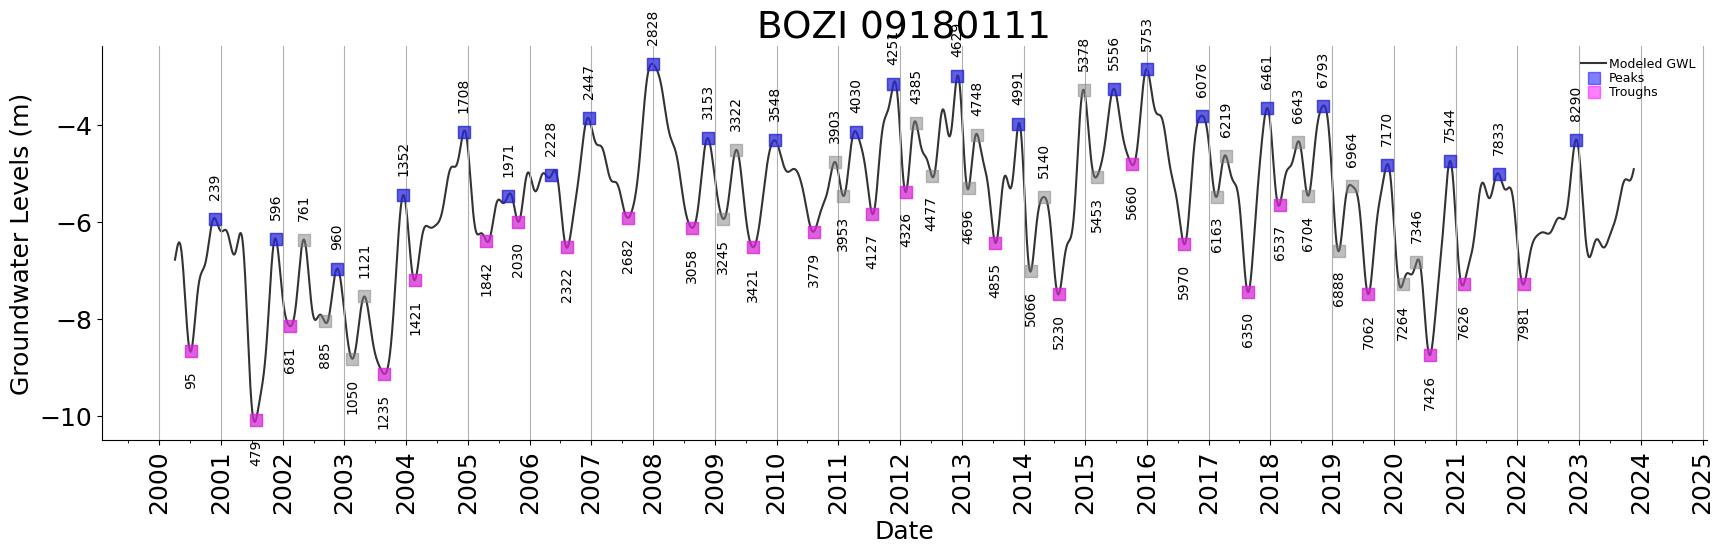

In [20]:
# Set the figure size and calculate the scaling factor
fig_width, fig_height = visualize.BASE_SIZE
scaling_factor = visualize.calculate_scaling_factor(fig_width, fig_height)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(fig_width * 1.5, fig_height * 2 / 3))

# Plot the original data and smoothed data
ax.plot(model_gwl_series, label="Modeled GWL", color="black", linewidth=1.5, alpha=0.8, zorder=1)

# Plot peaks and troughs using scatter plots
ax.scatter(
    combined_df.query("type=='peaks'")["dates"],
    combined_df.query("type=='peaks'")["values"],
    color="grey",
    marker="s",
    s=70,
    alpha=0.5,
    zorder=2,
)
ax.scatter(
    combined_df.query("type=='troughs'")["dates"],
    combined_df.query("type=='troughs'")["values"],
    color="grey",
    marker="s",
    s=70,
    alpha=0.5,
    zorder=2,
)

ax.scatter(
    final_filtered_df.query("type=='peaks'")["dates"],
    final_filtered_df.query("type=='peaks'")["values"],
    color="blue",
    marker="s",
    label="Peaks",
    s=70,
    alpha=0.5,
    zorder=3,
)
ax.scatter(
    final_filtered_df.query("type=='troughs'")["dates"],
    final_filtered_df.query("type=='troughs'")["values"],
    color="magenta",
    marker="s",
    label="Troughs",
    s=70,
    alpha=0.5,
    zorder=3,
)

# Annotate peaks with their corresponding indexes above the markers
for i in range(len(peaks_df)):
    ax.text(
        peaks_df.loc[i, "dates"],
        peaks_df.loc[i, "values"] + 0.4,
        str(peaks_df.loc[i, "indexes"]),
        ha="center",
        va="bottom",
        rotation="vertical",
        fontsize=10 * scaling_factor,
    )

# Annotate peaks with their corresponding indexes above the markers
for i in range(len(troughs_df)):
    ax.text(
        troughs_df.loc[i, "dates"],
        troughs_df.loc[i, "values"] - 0.4,
        str(troughs_df.loc[i, "indexes"]),
        ha="center",
        va="top",
        rotation="vertical",
        fontsize=10 * scaling_factor,
    )


# Configure the axis labels, title, and font scaling using visualize.py
visualize.configure_axis(
    ax=ax, xlabel="Date", ylabel="Groundwater Levels (m)", title=f"{station} {wellcode}", scaling_factor=scaling_factor
)

# Configure the legend
visualize.configure_legend(ax=ax, scaling_factor=0.5, frameon=False)

# Configure ticks (datetime for x-axis)
visualize.configure_datetime_ticks(ax=ax, axis="x", major_interval=12, minor_interval=6, date_format="%Y")

# Adjust layout and set x-axis label rotation
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

# Optional: Save the plot to a file (commented out by default)
output_savename = f"{station}_{wellcode}"
savepath = f"temp3_v2\\{output_savename}.png"
# visualize.save_figure(fig, savepath)

# Close the plot to free memory (especially important in loops)
plt.show()